This file is the main file where we define the problem data, initiate model and train the model

1. First we import all the relevant classes and libraries

In [83]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/PINN

from physicsinformed_1 import PhysicsInformedNN # py file which contains custom class for training

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PINN


In [84]:
import numpy as np
import torch
import scipy.io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [85]:
N_train = 5000
    
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
    
    # Load Data
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
           
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
    
N = X_star.shape[0]
T = t_star.shape[0]

In [86]:
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

In [87]:
UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

In [88]:
x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

In [89]:
# Training Data    
idx = np.random.choice(N*T, N_train, replace=False)
x_train = torch.tensor(x[idx,:], requires_grad=True, dtype=torch.float).to(device)
y_train = torch.tensor(y[idx,:], requires_grad=True, dtype=torch.float).to(device)
t_train = torch.tensor(t[idx,:], requires_grad=True, dtype=torch.float).to(device)
u_train = torch.tensor(u[idx,:], requires_grad=True, dtype=torch.float).to(device)
v_train = torch.tensor(v[idx,:], requires_grad=True, dtype=torch.float).to(device)

In [90]:
# Training
PINN = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
PINN.model.to(device)
PINN.train(500)



AttributeError: ignored

In [ ]:
# Test Data
snap = np.array([100])
x_star = torch.tensor(X_star[:,0:1], requires_grad=True,dtype=torch.float)
y_star = torch.tensor(X_star[:,1:2], requires_grad=True,dtype=torch.float)
t_star = torch.tensor(TT[:,snap], requires_grad=True,dtype=torch.float)

u_star = torch.tensor(U_star[:,0,snap],dtype=torch.float)
v_star = torch.tensor(U_star[:,1,snap], dtype=torch.float)
p_star = torch.tensor(P_star[:,snap],dtype=torch.float)

In [ ]:
model.lambda_1

In [ ]:
u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)
u_pred, v_pred, p_pred = u_pred.detach().numpy(), v_pred.detach().numpy(), p_pred.detach().numpy()
lambda_1_value = model.lambda_1.item()
lambda_2_value = model.lambda_2.item()

In [ ]:
# Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - 0.01)/0.01 * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 8.123069e-02
Error v: 2.732245e-01
Error p: 4.228810e+00
Error l1: 12.59364%
Error l2: 26.26974%


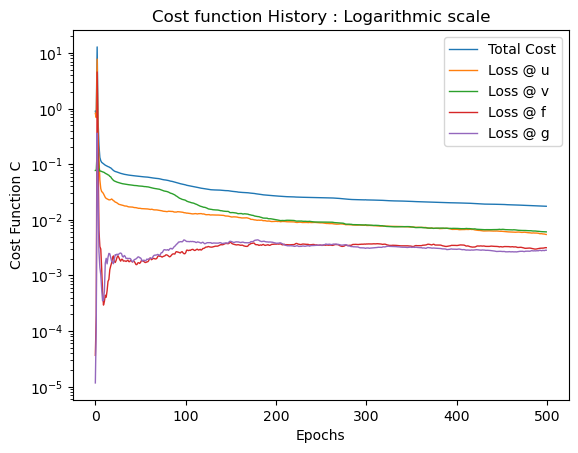

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.total_loss,label = "Total Cost",lw = 1)
plt.plot(model.u_pred,label = "Loss @ u",lw = 1)
plt.plot(model.v_pred ,label = "Loss @ v",lw = 1)
plt.plot(model.f_u_pred,label = "Loss @ f",lw = 1)
plt.plot(model.f_v_pred,label = "Loss @ g",lw = 1)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Cost Function C")
plt.legend()
plt.title("Cost function History : Logarithmic scale")
plt.show()

In [ ]:
model.lambda_2

Parameter containing:
tensor(0.0126, requires_grad=True)

In [ ]:
sum(p.numel() for p in model.model.parameters())

1382

In [ ]:
[module for module in model.model.modules()]

[Sequential(
   (0): Linear(in_features=3, out_features=20, bias=True)
   (1): Tanh()
   (2): Linear(in_features=20, out_features=20, bias=True)
   (3): Tanh()
   (4): Linear(in_features=20, out_features=20, bias=True)
   (5): Tanh()
   (6): Linear(in_features=20, out_features=20, bias=True)
   (7): Tanh()
   (8): Linear(in_features=20, out_features=2, bias=True)
 ),
 Linear(in_features=3, out_features=20, bias=True),
 Tanh(),
 Linear(in_features=20, out_features=20, bias=True),
 Tanh(),
 Linear(in_features=20, out_features=20, bias=True),
 Tanh(),
 Linear(in_features=20, out_features=20, bias=True),
 Tanh(),
 Linear(in_features=20, out_features=2, bias=True)]